In [20]:
import numpy as np
import matplotlib.pyplot as plt
from master_lib.utils import files_and_directories
import pandas as pd
from master_lib.model.generator import DataGenerator
from master_lib.loader.data_loader import dataset_partition
from master_lib.model.callbacks import BCP
from typing import List

# model definition
import PIL
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = 4

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

model_archive = r'C:\Users\MikołajStryja\Documents\Studia\master\trained_models'
model_name = 'Model2_histogram_normal_equalization'

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14361243750204714658
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5642643360341646352
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [21]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7, verbose=1)

filepath = r'C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(filepath, model_name), monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learning_rate = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=1
)

bcp_callback = BCP()

In [22]:
dataset_path = r'C:\Users\MikołajStryja\Documents\Studia\master\dataset.json'
dataset = files_and_directories.load_json(dataset_path)
dataset_images = r'C:\Users\MikołajStryja\Documents\Studia\siim-covid19-detection'
dataset = files_and_directories.load_json(dataset_path)
train_imgs = files_and_directories.list_train_images(dataset_images)
Xtrain, Xval, Xeval = dataset_partition(train_imgs)
training_generator = DataGenerator(Xtrain, batch_size=32, equalization=1)
validation_generator = DataGenerator(Xval, batch_size=32, equalization=1)
evaluation_generator = DataGenerator(Xeval, batch_size=32, shuffle=False)

dataset length: 6054
Evaluation Cases: 150
Train cases: 4133
Validation cases: 1771


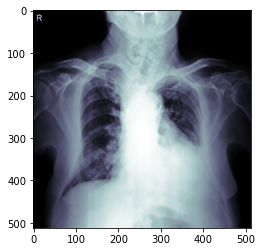

In [16]:
test_img = training_generator.__getitem__(0)
plt.imshow(test_img[0][0], cmap=plt.cm.bone)

In [24]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(512, 512, 1)),
    # tf.keras.Input(shape=(3,)),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', name="first_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (5, 5), padding='same', activation='relu', name="second_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (5, 5), padding='same', activation='relu', name="third_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', name="fourth_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(8, (3, 3), padding='same', activation='relu', name="fith_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

inputs = tf.keras.Input(shape=(512, 512, 1))


In [25]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 512, 512, 1)       0         
_________________________________________________________________
first_conv2d_filter (Conv2D) (None, 512, 512, 16)      416       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
second_conv2d_filter (Conv2D (None, 256, 256, 32)      12832     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
third_conv2d_filter (Conv2D) (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)       

In [26]:
model.fit(training_generator,
        epochs=20,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[early_stop, learning_rate, checkpoint, bcp_callback])

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
108/129 [========================>.....] - ETA: 3:01 - loss: 1.2291 - accuracy: 0.4742

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1582s 12s/step - loss: 1.2269 - accuracy: 0.4758 - val_loss: 1.1920 - val_accuracy: 0.4756

Epoch 00001: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.


C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1491s 12s/step - loss: 1.1809 - accuracy: 0.5194 - val_loss: 1.1623 - val_accuracy: 0.5432

Epoch 00002: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 15/129 [==>...........................] - ETA: 15:51 - loss: 1.2162 - accuracy: 0.5083

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1534s 12s/step - loss: 1.1478 - accuracy: 0.5354 - val_loss: 1.1584 - val_accuracy: 0.5256

Epoch 00003: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 59/129 [============>.................] - ETA: 9:43 - loss: 1.1287 - accuracy: 0.5482

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1543s 12s/step - loss: 1.1235 - accuracy: 0.5518 - val_loss: 1.1293 - val_accuracy: 0.5466

Epoch 00004: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474974513.
108/129 [========================>.....] - ETA: 2:53 - loss: 1.1029 - accuracy: 0.5619

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1507s 12s/step - loss: 1.1058 - accuracy: 0.5608 - val_loss: 1.1224 - val_accuracy: 0.5562

Epoch 00005: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 6/20

Epoch 00006: LearningRateScheduler setting learning rate to tf.Tensor(0.0009048374, shape=(), dtype=float32).
 13/129 [==>...........................] - ETA: 18:14 - loss: 1.1083 - accuracy: 0.5697

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1510s 12s/step - loss: 1.0842 - accuracy: 0.5739 - val_loss: 1.1196 - val_accuracy: 0.5591

Epoch 00006: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 7/20

Epoch 00007: LearningRateScheduler setting learning rate to tf.Tensor(0.0008187307, shape=(), dtype=float32).
  2/129 [..............................] - ETA: 21:44 - loss: 1.0533 - accuracy: 0.5625

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1485s 12s/step - loss: 1.0675 - accuracy: 0.5799 - val_loss: 1.1118 - val_accuracy: 0.5648

Epoch 00007: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 8/20

Epoch 00008: LearningRateScheduler setting learning rate to tf.Tensor(0.0007408181, shape=(), dtype=float32).
 55/129 [===========>..................] - ETA: 9:28 - loss: 1.0269 - accuracy: 0.5972

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1456s 11s/step - loss: 1.0350 - accuracy: 0.5889 - val_loss: 1.1358 - val_accuracy: 0.5602

Epoch 00008: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 9/20

Epoch 00009: LearningRateScheduler setting learning rate to tf.Tensor(0.0006703199, shape=(), dtype=float32).
 83/129 [==================>...........] - ETA: 5:59 - loss: 1.0066 - accuracy: 0.5975

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1458s 11s/step - loss: 1.0126 - accuracy: 0.5938 - val_loss: 1.1399 - val_accuracy: 0.5483

Epoch 00009: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 10/20

Epoch 00010: LearningRateScheduler setting learning rate to tf.Tensor(0.00060653046, shape=(), dtype=float32).
 87/129 [===================>..........] - ETA: 5:25 - loss: 0.9770 - accuracy: 0.6092

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1453s 11s/step - loss: 0.9700 - accuracy: 0.6148 - val_loss: 1.1648 - val_accuracy: 0.5426

Epoch 00010: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 11/20

Epoch 00011: LearningRateScheduler setting learning rate to tf.Tensor(0.00054881145, shape=(), dtype=float32).
 15/129 [==>...........................] - ETA: 15:21 - loss: 0.9911 - accuracy: 0.5979

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1456s 11s/step - loss: 0.9259 - accuracy: 0.6330 - val_loss: 1.1901 - val_accuracy: 0.5284

Epoch 00011: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 12/20

Epoch 00012: LearningRateScheduler setting learning rate to tf.Tensor(0.0004965851, shape=(), dtype=float32).
101/129 [======================>.......] - ETA: 3:39 - loss: 0.8653 - accuracy: 0.6544

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1451s 11s/step - loss: 0.8658 - accuracy: 0.6577 - val_loss: 1.3166 - val_accuracy: 0.5068

Epoch 00012: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 13/20

Epoch 00013: LearningRateScheduler setting learning rate to tf.Tensor(0.00044932874, shape=(), dtype=float32).
 54/129 [===========>..................] - ETA: 9:33 - loss: 0.8131 - accuracy: 0.6632

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1454s 11s/step - loss: 0.8196 - accuracy: 0.6669 - val_loss: 1.2695 - val_accuracy: 0.5199

Epoch 00013: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 14/20

Epoch 00014: LearningRateScheduler setting learning rate to tf.Tensor(0.00040656942, shape=(), dtype=float32).
 40/129 [========>.....................] - ETA: 11:54 - loss: 0.6916 - accuracy: 0.7328

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1455s 11s/step - loss: 0.7385 - accuracy: 0.7047 - val_loss: 1.4022 - val_accuracy: 0.5239

Epoch 00014: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Model2_histogram_normal_equalization\assets
Epoch 00014: early stopping


In [27]:
model.save(os.path.join(model_archive, model_name))

INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\trained_models\Model2_histogram_normal_equalization\assets


In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
epochs = model.history.epoch
keys = model.history.history.keys()
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

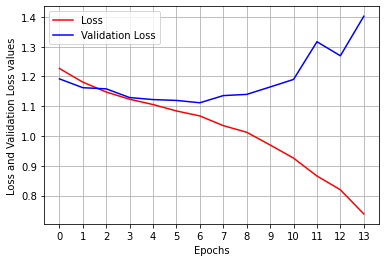

In [29]:
plt.plot(epochs, loss, 'r-', label='Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss and Validation Loss values')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_loss.png'))

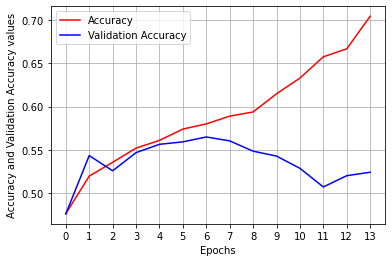

In [30]:
plt.plot(epochs, acc, 'r-', label='Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Validation Accuracy values')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_acc.png'))

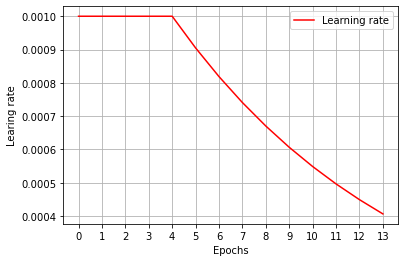

In [31]:
lr = model.history.history['lr']

plt.plot(epochs, lr, 'r-', label='Learning rate')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Learing rate')
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_lr.png'))

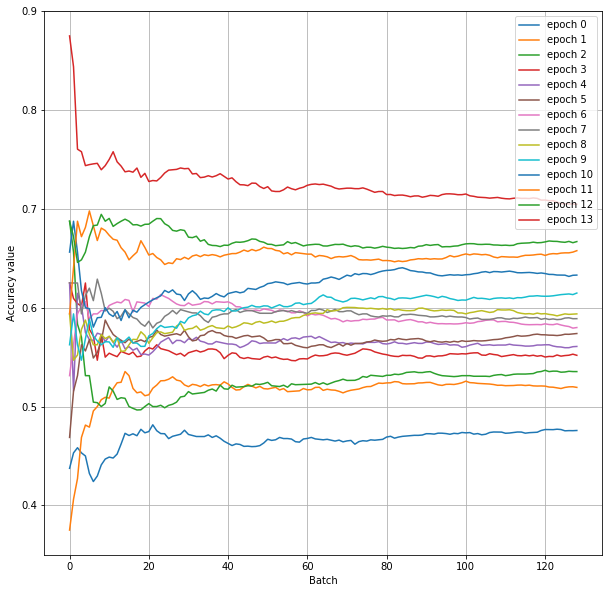

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
epochs = model.history.epoch
steps_per_epoch = int(len(BCP.batch_loss)/len(epochs))

for i in epochs:
    ax.plot(range(steps_per_epoch), BCP.batch_accuracy[i*steps_per_epoch:(i+1)*steps_per_epoch], label=f'epoch {i}')

ax.legend(loc='upper right')
ax.set_xlabel('Batch')
ax.set_ylabel('Accuracy value')
ax.grid()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_acc_per_epoch.png'))

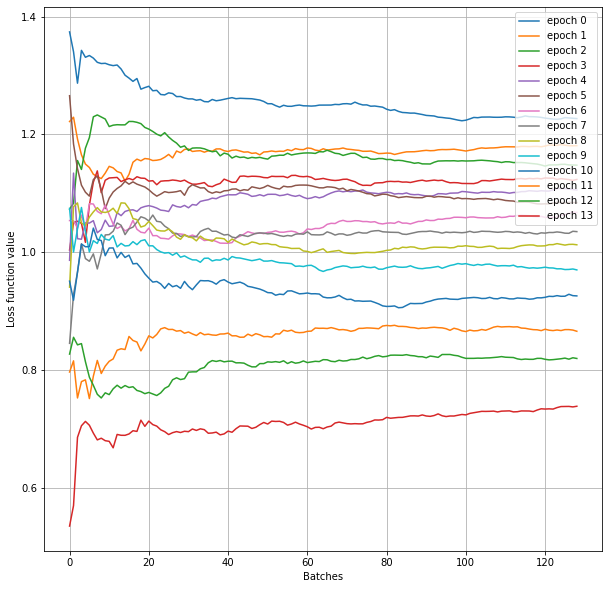

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
epochs = model.history.epoch
steps_per_epoch = int(len(BCP.batch_loss)/len(epochs))

for i in epochs:
    ax.plot(range(steps_per_epoch), BCP.batch_loss[i*steps_per_epoch:(i+1)*steps_per_epoch], label=f'epoch {i}')

ax.legend(loc='upper right')
ax.set_xlabel('Batches')
ax.set_ylabel('Loss function value')
ax.grid()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_loss_per_epoch.png'))

In [34]:
results = model.predict(evaluation_generator)

for elem in results:
    max_value = np.where(elem == np.amax(elem))
    elem[max_value] = 1
    elem[elem != 1] = 0

from master_lib.loader.data_loader import evaluate_categories
gt = []
for elem in Xeval[:len(results)]:
    gt.append(evaluate_categories(os.path.basename(elem)))

In [35]:
m = tf.keras.metrics.Precision()
r = tf.keras.metrics.Recall()
m.update_state(results, gt)
r.update_state(results, gt)
precision = m.result().numpy()
recall = r.result().numpy()
precision, recall, 2*precision*recall/(precision + recall)

(0.5703125, 0.5703125, 0.5703125)

In [36]:
min(loss), min(val_loss)

(0.7385385632514954, 1.1117627620697021)

In [37]:
max(acc), max(val_acc)

(0.7046996355056763, 0.5647727251052856)